# Tutorial 3: Initializing a meso-scale chain

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
from gstatsMCMC import MCMC
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg

### First, load data and get some important statistics information

In [7]:
# load compiled bed elevation measurements
df = pd.read_csv('DenmanDataGridded.csv')

In [8]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 1000

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [9]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmachine_bed = df['bedmap_surf'].values.reshape(xx.shape) - bedmachine_thickness

In [10]:
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmachine_bed)
df['cond_bed'] = cond_bed.flatten()

what is cond_bed?

In [11]:
# # find variograms
# df_bed = df.copy()

# df_sampled = df.copy()
# df_bed = df_bed[df_bed["cond_bed"].isnull() == False]
# data = df_bed['cond_bed'].values.reshape(-1,1)
# coords = df_bed[['x','y']].values
# roughness_region_mask = (df_bed['bedmap_mask'].values)==1 # Read BedMachine user guide for the meaning of values == 2 https://nsidc.org/data/nsidc-0756/versions/3

# nst_trans, Nbed_radar, varios, fig = MCMC.fit_variogram(data, coords, roughness_region_mask, maxlag=70000, n_lags=70)

In [12]:
# normalize the conditioning bed data, saved to df['Nbed']
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

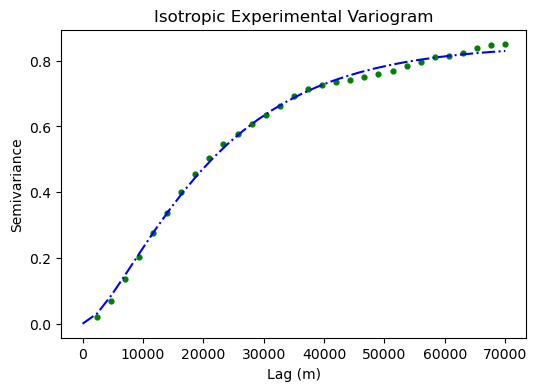

In [28]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 70000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False, model='matern')

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [29]:
V1_p

[56751.15173430747, 0.8479248734439089, 0.9699115732966279, 0]

In [15]:
V1_p = [56751.15173430747, 0.8479248734439089, 0.9699115732966279, 0]

Why I did this

In [16]:
sgs_bed = np.loadtxt('sgs_bed.txt')
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

In [18]:
# initiate conditioning data and a mask of conditioning data
cond_bed = df['cond_bed'].values.reshape(xx.shape)
data_mask = ~np.isnan(cond_bed)

### Then initiating the chain

#### Initiate an object of the class chain_crf

Let's first initiate the chain. Here, we created an object of the class chain_crf. This initialization process requires several input that are essential for later calculations

In [19]:
grounded_ice_mask = (bedmap_mask == 1)

In [22]:
crf_1 = MCMC.chain_crf(xx, yy, sgs_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

before running the chain, please set where the block update will be using chainname.set_high_vel_region(update_in_region, region_mask)
then please set up the loss function using either chainname.set_loss_type or chainname.set_loss_func
an RandField object also need to be created correctly and passed in chainname.set_crf_data_weight(RF) and in chain.run(n_iter, RF)


Now, the object 'crf_1' have all the properties you have assigned in the initialization process. Try typing *crf_1.xx* or *crf_1.cond_bed*, or any other argument to check them.

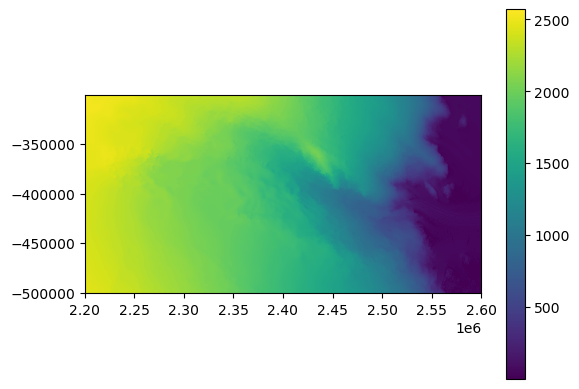

In [23]:
plt.pcolormesh(xx, yy, crf_1.surf)
plt.axis('scaled')
plt.colorbar()

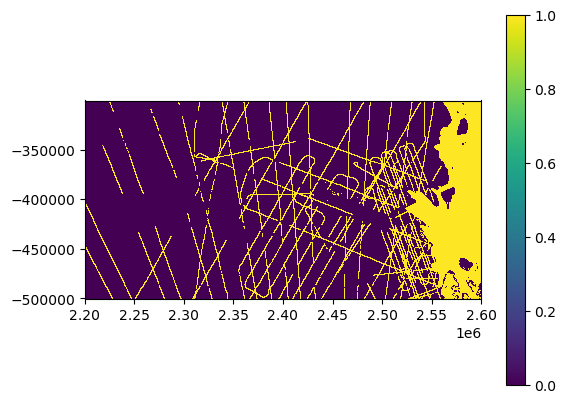

In [24]:
plt.pcolormesh(xx, yy, crf_1.data_mask)
plt.axis('scaled')
plt.colorbar()

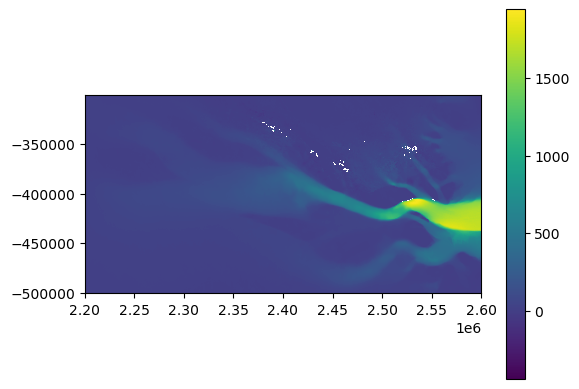

In [25]:
plt.pcolormesh(xx, yy, crf_1.velx)
plt.axis('scaled')
plt.colorbar()

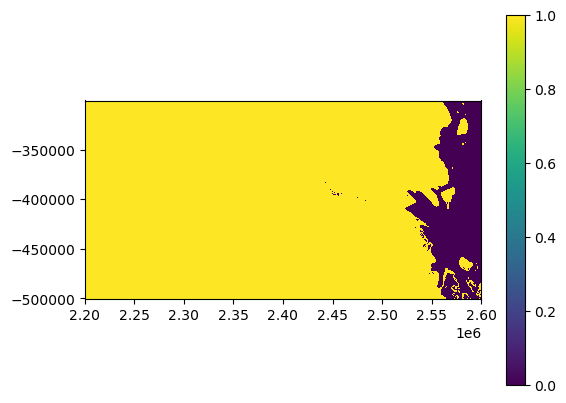

In [26]:
plt.pcolormesh(xx, yy, crf_1.grounded_ice_mask)
plt.axis('scaled')
plt.colorbar()

The second function required, is *set_high_vel_region*. In this function, the first boolean argument decide whether the MCMC update will be inside the high velocity, the second argument specify the exact region of high velocity (where the high_vel_mask == 1)

In [27]:
crf_1.set_high_vel_region(True,highvel_mask)

We also want to specify how we want to define the loss function used in the chain.

*map_func* determine the distribution of mass conservation residuals, whereas the *diff_func* determine the distribution of the difference between radar measurements and simulated topography. If the residuals has a Gaussian distribution, the corresponding function will be 'sumsquare'. If you do not want to include either of these loss, simple put *map_func = None* or *diff_func = None*. 

*sigma_mc* and *sigma_data* determine the standard deviation of the distribution of mass conservation residual or differences to radar data. *massConvInRegion* and *dataDiffInRegion* specify whether the two losses should be calculated for only inside the high velocity region or not

In [30]:
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

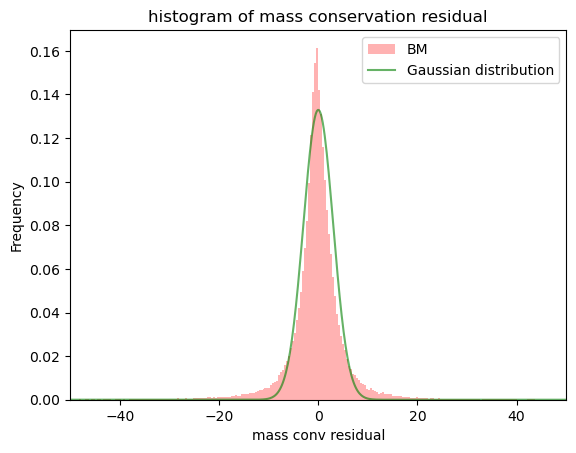

In [33]:
sigma3 = 3
xl3=np.linspace(-100, 100, num=1000)
gaussian_model=1/(sigma3*np.sqrt(2*np.pi))*np.exp(-0.5*np.square(xl3/sigma3))

mc_res_bm_sr2 = mc_res_bm[highvel_mask==1]
mc_res_bm_sr2_f = mc_res_bm_sr2.flatten()
mc_res_bm_sr2_f = mc_res_bm_sr2_f[~np.isnan(mc_res_bm_sr2_f)]

plt.hist(mc_res_bm_sr2_f, bins=5000, facecolor='red', alpha=0.3,density=True,label='BM')
plt.plot(xl3, gaussian_model, color='Green',alpha=0.6, label='Gaussian distribution')
plt.xlim([-50,50]);

plt.legend()
plt.xlabel('mass conv residual');
plt.ylabel('Frequency');
plt.title('histogram of mass conservation residual')
plt.show()

In [34]:
crf_1.set_loss_type(map_func='sumsquare', sigma_mc=3, massConvInRegion=False)

#### Initiate an object of the class RandField

Next step is to set up the parameters of the random field perturbation

In [36]:
range_max_x = 40e3 #in terms of meters in lateral dimension, regardless of resolution of the map
range_max_y = 40e3
range_min_x = 10e3
range_min_y = 10e3
scale_min = 50 #in terms of meters in vertical dimension, how much you want to multiply the perturbation by
scale_max = 150
nugget_max = 0
random_field_model = 'Matern' # currently only supporting 'Gaussian' or 'Exponential'
isotropic = True
smoothness = V1_p[2]

rf1 = MCMC.RandField(range_max_x, range_max_y, range_min_x, range_min_y, scale_min, scale_max, nugget_max, random_field_model, isotropic, smoothness = smoothness)

before using the RandField object in the MCMC chain, please set up its block sizes using set_block_sizes function, and set up conditional weight using set_block_param function


Then we can set up the size of the blocks used in the update

*set_block_sizes* function create a list of possible block sizes, which will be accessible via rf1.pairs after the function is called.

*set_block_sizes* function also has an optional argument *steps*, it specify how many 'steps' between the min_block and max_block will be divided into. For example, for min_block_x = 20 and max_block_x = 50, steps = 4 will divide the range into [20, 30, 40, 50]. For min_block_y = 10 and max_block_y = 55, it will divide the range into [10, 25, 40, 55]. Then each size on the list for x will pair up with all size on the list for y, creating a list of following

rf1.pairs = [[20,10],[20,25],[20,40],[20,55],[30,10],[30,25],[30,40],[30,55],[40,10],[40,25],[40,40],[40,55],[50,10],[50,25],[50,40],[50,55]]

When randomly deciding the size of the block, one of the size on the list will be chosen and will be used

In [37]:
min_block_x = 20
max_block_x = 100
min_block_y = 20
max_block_y = 100
rf1.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)

Finally, if you wish to use conditional block update, then the RandField object requires specifying the logistic function used to calculate the conditioning weight of the random field

The logistic function is used to calculate the weight for conditioning to the edge of the block and the weight for conditioning to radar measurements. When updating the field, the weight will be 1 at conditioning data and block edges, and it logistically decays to 0 at location *max_dist* away from any conditioning data

In [38]:
logis_func_L = 2
logis_func_x0 = 0
logis_func_k = 6
logis_func_offset = 1
max_dist = V1_p[0] # set to the distance between two points on the map where the correlation vanish / is minimal

rf1.set_block_param(logis_func_L, logis_func_x0, logis_func_k, logis_func_offset, max_dist, resolution)

#### Run the Markov chain

At last, these information need to be known to the crf chain. The function *set_crf_data_weight* calculate the weight for conditioning to the radar measurements

In [ ]:
crf_1.set_crf_data_weight(rf1)
crf_1.set_update_type('CRF_weight')

And then we can start the chain by specifying how many iterations it should go through

In [ ]:
seed = 0
randomGenerator = np.random.default_rng(seed)

bed_cache, loss_mc_cache, loss_data_cache, loss_cache, step_cache, resampled_times, blocks_cache = crf_1.run(n_iter=5000, RF=rf1, rng=randomGenerator)